# Домашнее задание

В этом домашнем задании вам предстоит обучить DCGAN для генерации лиц и изучить латентное пространство. Модель DCGAN аналогична той, которая использовалась на лекции. Рекомендуем вам подробно ознакомится с приведенным кодом, чтобы лучше понимать как все устроено “изнутри”.


В качестве напоминания приводим ниже иллюстрацию архитектуры ([источник](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN) иллюстрации).

![alt text](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN/raw/master/tensorflow_DCGAN.png)

In [1]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import time
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

In [2]:
class DCGAN(tf.keras.Model):
    def __init__(self, image_size, output_path, num_channels=1, z_dim=100,
                 G_h_size=128, D_h_size=128):
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.multiply = int(np.log2(self.image_size / 8)) # столько раз нужно применить апсемплинг или даунсемплинг
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2) и наоборот
                                                
        self.output_path =  Path(output_path)
        (self.output_path / "model").mkdir(exist_ok=True)

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
         
        self.gen_loss_hist = []
        self.disc_loss_hist = []
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)
        self.start_iteration = 0

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):
        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
        

    def _build_generator(self):
        
        model = tf.keras.Sequential()
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))

        model.add(Conv2DTranspose(self.G_h_size * 2**self.multiply,
                                  kernel_size=4, use_bias=False, 
                                  kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        
        for i in range(self.multiply):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 2**self.multiply // 2**(i+1))) 
        assert model.output_shape[1:] == (self.image_size // 2, self.image_size // 2, self.D_h_size), f"{model.output_shape, self.D_h_size}"
        
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        for i in range(self.multiply):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        assert model.output_shape[1:] == (4, 4, self.D_h_size * 2**self.multiply), f"{model.output_shape}"
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init, use_bias=False)) # без активации !
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def save_imgs(self, epoch):
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"{epoch}.png")
        plt.show()
    
    def train(self, dataset, num_iters=2000, show_every=25):
        start = time.time()
        iters = self.start_iteration
        for image_batch in dataset:
            print(".", end='')
            gen_loss, disc_loss = self.train_step(image_batch)
            
            self.disc_loss_hist.append(disc_loss.numpy())
            self.gen_loss_hist.append(gen_loss.numpy())    
            
            if iters % show_every == 0:
                display.clear_output(wait=True)
                plt.figure()
                plt.plot(self.disc_loss_hist, label="Discriminator loss")
                plt.plot(self.gen_loss_hist, label="Generator loss")
                plt.legend(loc="best")
                plt.figure()
                self.save_imgs(f"{iters}")
                self.save_weights(str(self.output_path / "model" / "dcgan_model"), save_format='tf')
                
                print(f"\n{iters}/{num_iters}")
                print(f'Time elapsed from start {time.time() - start} sec')
                
            iters += 1
            if iters > num_iters:
                print(f'Finished. Time elapsed from start {time.time() - start} sec')
                return
        


## Загрузка датасета

In [3]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:03, 34.6MB/s]


## Задание 1. Создание генераторов данных

Реализуйте генератор изображений с указанными ниже BATCH_SIZE и IMAGE_SIZE. Используйте для этого ImageDataGenerator, flow_from_dataframe или flow_from_directory. Данные расположены в папке "/tmp/UTKFace". Классы в этом задании нам не нужны.

*Интенсивности картинок должны быть нормализованы от -1 до 1.*

In [4]:
BATCH_SIZE = 128
IMAGE_SIZE = 32

In [ ]:
import os
os.listdir("/tmp/UTKFace/")

In [91]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocessing_function(img):
    return img.astype('float32') / 127.5 - 1

image_generator = ImageDataGenerator(preprocessing_function=preprocessing_function)\
    .flow_from_directory(
        '/tmp/',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode=None
    )

Found 23708 images belonging to 4 classes.


Shape test passed


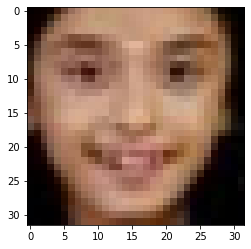

In [95]:
sample = next(image_generator)
assert sample.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), f"Размер батча должен быть: {(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)}.  Получен {sample.shape}"
print("Shape test passed")
# если препроцессинг правильный, то картинка ниже имеет реалистичные цвета и matplotlib не ругается
plt.imshow((sample[0] + 1.) / 2)

## Задание 2. Обучение DCGAN

В этом задании вам нужно просто запустить обучение GAN. С указанными параметрами оно займет около часа.

Предварительно заманутите Google Drive, для сохранения промежуточных результатов и весов модели.

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [98]:
output = Path("/content/drive/My Drive/gan_utk_32")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

gan = DCGAN(image_size=IMAGE_SIZE, num_channels=3, output_path=output, 
           z_dim=100, D_h_size=128, G_h_size=128)

In [ ]:
# если при запуске обучения вы видите "WARNING:tensorflow:Entity <bound method DCGAN.train_step ...", 
# раскомментируйте строчку ниже, установите пакет и рестартните runtime
# это временный баг в tf из-за изменения версии gast
#! pip install 'gast==0.2.2'

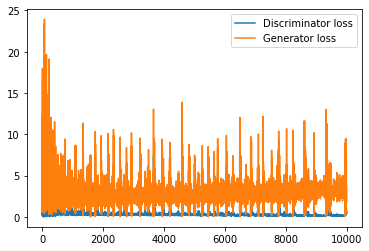

<Figure size 432x288 with 0 Axes>

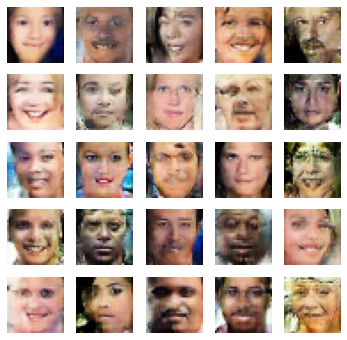


10000/10000
Time elapsed from start 2476.261645555496 sec
Finished. Time elapsed from start 2476.2616822719574 sec


In [99]:
images = list(output.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan.train(image_generator, 10000, 50)

После того как модель обучена, можно посмотреть какие лица она научилась генерировать!

In [51]:
def generate_data(latent_vector, generator):
    """
    Для того чтобы сгенерировать объект нам нужен генератор и латентный вектор
    """
    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

Вектор:  [-1.1693863   1.6631515  -0.01415014 -0.9528939  -0.0152541   1.2788485
 -1.9702721  -0.85289884  1.57821     0.18050773]


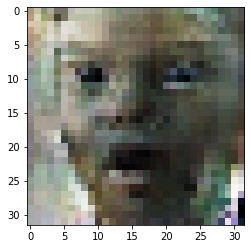

In [104]:
v1 = tf.random.normal([1, 100]) 
print("Вектор: ", v1.numpy()[0, :10]) 
_ = plt.imshow(generate_data(v1, gan.generator)[0]) 

## Задание 3. Поиск вектора улыбки

В этом задании вам предстоит найти “вектор улыбки” и доказать что он таковым является. 

Что это означает? Как мы уже знаем, GAN генерирует данные из случайных векторов из определенного распределения. Такие вектора образуют латентное пространство. Напомню аналогию с бегунками в компьютерной игре - в этом случае латентное пространство задается всеми положениями бегунков, которым соответствуют реалистичные лица. 

В нашем случае GAN тоже выучил нечто подобное, ведь ему хватает 100 чисел, чтобы создать лицо -- это и есть его бегунки. Можно увидеть, что среди сгенерированных лиц имеются лица с улыбкой и без. А значит можно предположить, что какое-то определенное расположение этих бегунков (определенные значения латентного вектора) отвечают за улыбку. Тогда можно считать, что есть определенная комбинация этих 100 чисел, прибавив которую к вектору соответствующему нейтральному лицу можно получить это же лицо, только с улыбкой. Эти 100 чисел мы и называем “вектор улыбки”. 


In [105]:
def generate_many(generator, n):
    vis_noise = np.random.normal(0, 1, (n, 100)).astype(np.float32)
    gen_imgs = generator(vis_noise, training=False)
    show_many(gen_imgs, "Generated images")
    return vis_noise

def show_many(images, title=""):
    w = h = int(np.sqrt(len(images)))
    images = (np.clip(images, -1, 1) + 1.) / 2. 
    
    fig, axs = plt.subplots(w, h, figsize=(w, h))
    if title != "":
        fig.suptitle(title)

    cnt = 0
    for i in range(h):
        for j in range(w):
            axs[i, j].imshow(images[cnt, :, :, :])
            axs[i, j].set_title(f"{cnt}")
            axs[i, j].axis('off')
            cnt += 1
    plt.subplots_adjust(wspace=.5)
    

### a) Интерполяция
Используйте функцию show_interpolation для отображения превращения лица соответствующего латентному вектору `v_1` в лицо, соответствующее `v_2`. Вектора определите случайно из правильного распределения.



In [108]:
def show_interpolation(v_1, v_2, generator, n=20):
    """
    Превращает v_1 в v_2 за n шагов, изображая 
    картинки соответствующие промежуточным векторам

    """
    fig, axs = plt.subplots(1, n, figsize=(n,1))
    for i, alpha in enumerate(np.linspace(0, 1, n)):
        curr_vec = v_1 * (1-alpha) + v_2 * alpha
        image = generate_data(curr_vec, gan.generator)[0]
        axs[i].imshow(image)
        axs[i].axis('off')

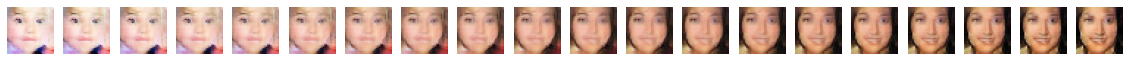

In [113]:
v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])

show_interpolation(v1, v2, generate_data)

## b) Поиск вектора улыбки

Придумайте каким образом найти *вектор улыбки* в латентном пространстве и докажите визуально, что это именно он -- превратив нейтрального человека в улыбающегося и наоборот.

*Вам могут пригодится функции generate_many и show-interpolation*

Результат должен получиться похожим на:

<img alt="smile.png" src="https://sun9-51.userapi.com/c857228/v857228713/aea82/t93eL7L3zbU.jpg">  
Если затрудняетесь – ниже есть подсказка. Но обязательно сначала подумайте над задачей сами)

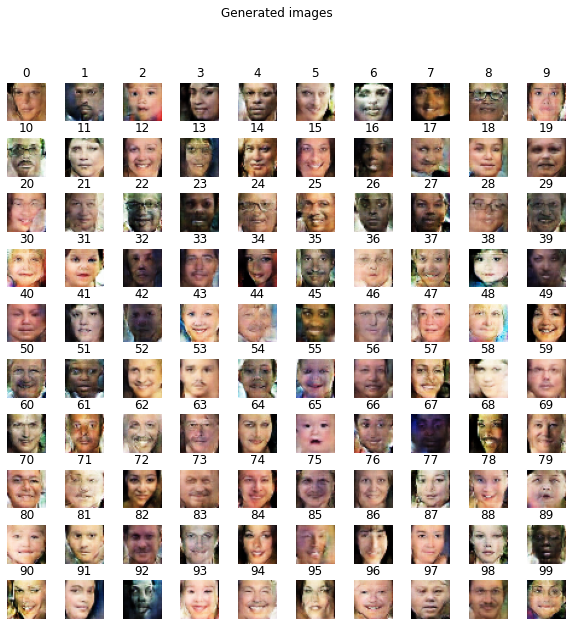

In [130]:
kek = generate_many(gan.generator, 100)

In [137]:
smilling = (kek[5] + kek[12] + kek[15] + kek[25] + kek[37] +\
            kek[43] + kek[45] + kek[49] + kek[52] + kek[55] +\
            kek[57] + kek[62] + kek[84] + kek[85] + kek[90] +\
            kek[93] + kek[94])/17
not_smiling = (kek[0] + kek[1] + kek[4] + kek[9] + kek[18] +\
               kek[21] + kek[26] + kek[41] + kek[46] + kek[53] +\
               kek[59] + kek[63] + kek[67] + kek[69] + kek[81] +\
               kek[88] + kek[89])/17      
smile_vector = smilling - not_smiling      

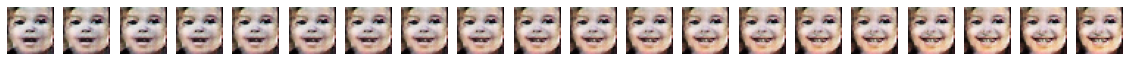

In [139]:
# нейтральный человек ------> с улыбкой
v1 = tf.random.normal([1, 100])

show_interpolation(v1, v1+smile_vector, generate_data)

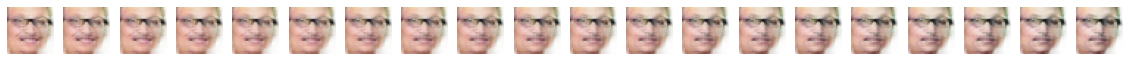

In [145]:
# человек с улыбкой ------> нейтральный
# нейтральный человек ------> с улыбкой
v1 = tf.random.normal([1, 100])

show_interpolation(v1, v1-smile_vector, generate_data)